# Self-supervised DAS denoising 

In [1]:
import gc
import h5py
import torch
import scipy
import numpy as np
import torch.nn as nn
from das_util import try_gpu
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from scipy.signal.windows import tukey
from torch.utils.data import DataLoader
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from sklearn.model_selection import train_test_split

In [2]:
def light_tukey(win_len, alpha=0.5, taper_level=0.5):
    org_func = scipy.signal.windows.tukey(win_len, alpha)
    new_func = (1 - taper_level) * org_func + taper_level
    
    return new_func

### Option 1: read raw data

In [ ]:
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_11_11.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_11.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:]
    
sample_rate = 25
dchan = 10
    
tmp = np.append(quake2[:,:4500,:], quake1[:,:4500,:], axis=0)

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, tmp, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)

### Option 2: read the raw and FK-filtered data

In [13]:
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_11_02.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:]
    label1 = f['fk_quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:]
    label2 = f['fk_quake'][:]

In [14]:
sample_rate = 25
dchan = 10
    
tmp_q = np.append(quake2[:,:4500,:], quake1[:,:4500,:], axis=0)
tmp_l = np.append(label2[:,:4500,:], label1[:,:4500,:], axis=0)

del quake1, quake2, label1, label2
gc.collect()

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt_q = filtfilt(b, a, tmp_q, axis=2)
filt_l = filtfilt(b, a, tmp_l, axis=2)
rawdata = filt_q / np.std(filt_q, axis=(1,2), keepdims=True)
fkdata = filt_l / np.std(filt_l, axis=(1,2), keepdims=True) * light_tukey(1500, alpha=0.3, taper_level=0.3)

del tmp_q, tmp_l, filt_q, filt_l
gc.collect()

0

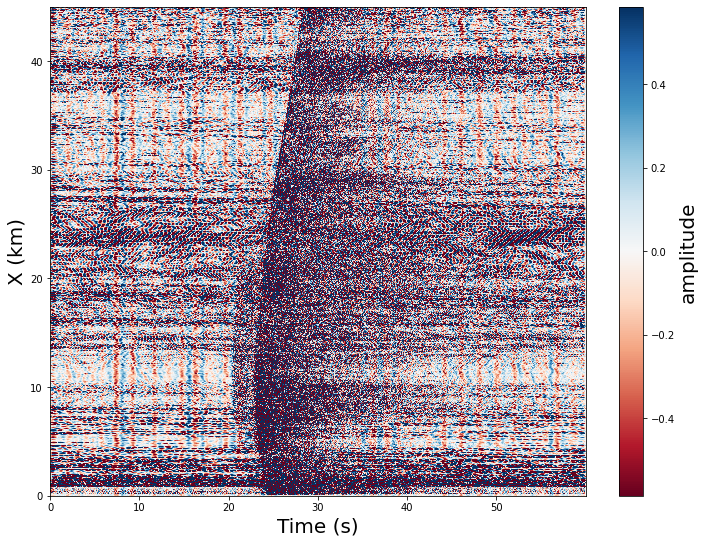

In [5]:
# %% visualize data
time_data = rawdata[2]
plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 4500, 1000), (np.arange(0, dchan*4500, 1000*dchan)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

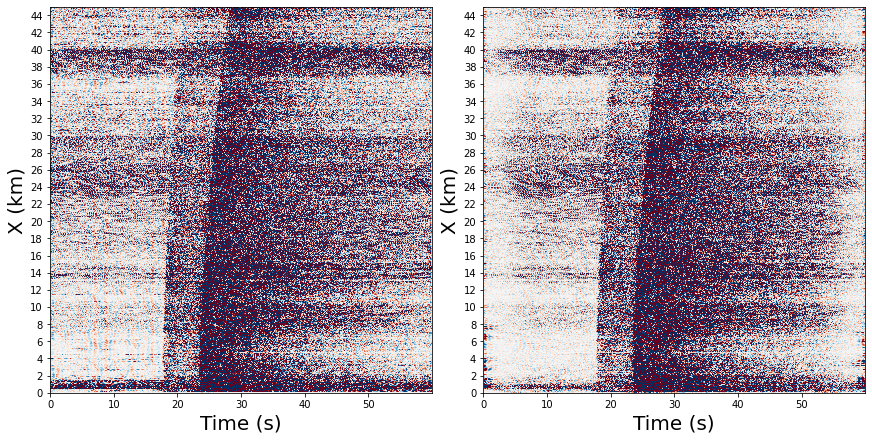

In [19]:
# %% visualize data and label
data_in = rawdata[12]
data_lb = fkdata[12]
fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
cmap=plt.cm.get_cmap('RdBu'); max_amp = np.median(np.fabs(data_in))*2
x, y=np.arange(data_in.shape[1]), np.arange(data_in.shape[0])

ax[0].pcolormesh(x, y, data_in, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)

ax[1].pcolormesh(x, y, data_lb, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 1500, 250)) 
    ax[i].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
    ax[i].set_yticks(np.arange(0, 4500, 200))
    ax[i].set_yticklabels((np.arange(0, dchan*4500, 200*dchan)/1000).astype(int))
    ax[i].set_xlabel("Time (s)", fontsize=20)
    ax[i].set_ylabel("X (km)", fontsize=20)


### Option 1: input=target

In [ ]:
# %% Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, rawdata,
                                        train_size=0.7,
                                        random_state=111)
X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

training_data = dataflow(X_tr, mask_ratio=0.5)
validation_data = dataflow(X_va, mask_ratio=0.5)
test_data = dataflow(X_te, mask_ratio=0.5)

del tmp, filt, rawdata, X, Y
gc.collect()

### Option 2: input !=target

In [7]:
# %% Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, fkdata,
                                        train_size=0.7,
                                        random_state=111)

del rawdata, fkdata
gc.collect()

X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

training_data = datalabel(X_tr, Y_tr, mask_ratio=0.5, stride=1500, n_masks=5)
validation_data = datalabel(X_va, Y_va, mask_ratio=0.5, stride=1500, n_masks=5)
# test_data = datalabel(X_te, Y_te, mask_ratio=0.5)

del X, Y, X_tr, Y_tr, X_va, Y_va, X_te, Y_te
gc.collect()

(5940, 1500, 1500)
(1275, 1500, 1500)


0

### Construct the neural network

In [8]:
""" Initialize the U-net model """
model = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
devc = try_gpu(i=0)
model = nn.DataParallel(model, device_ids=[0,1,2,3])  # comment if gpus<4 
model.to(devc)

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

### Training

In [9]:
# %% Hyper-parameters for training
batch_size = 64
lr = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.8, 
                                                         patience=5, 
                                                         threshold=0.001, 
                                                         threshold_mode='rel', 
                                                         cooldown=0, 
                                                         min_lr=1e-6, 
                                                         eps=1e-08, 
                                                         verbose=True)

train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=False)
validate_iter = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [10]:
model, \
avg_train_losses, \
avg_valid_losses = train_augmentation(train_iter,
                                   validate_iter,
                                   model,
                                   loss_fn,
                                   optimizer,
                                   lr_schedule=lr_schedule,
                                   epochs=350,
                                   patience=20,
                                   device=devc,
                                   minimum_epochs=50)

[  1/350] train_loss: 36.56567 valid_loss: 0.25434 time per epoch: 96.623 s
[  2/350] train_loss: 0.24013 valid_loss: 0.24890 time per epoch: 92.097 s
[  3/350] train_loss: 0.23676 valid_loss: 0.24704 time per epoch: 92.082 s
[  4/350] train_loss: 0.23433 valid_loss: 0.24331 time per epoch: 92.264 s
[  5/350] train_loss: 0.23009 valid_loss: 0.23958 time per epoch: 93.097 s
[  6/350] train_loss: 0.22696 valid_loss: 0.23684 time per epoch: 92.853 s
[  7/350] train_loss: 0.22404 valid_loss: 0.23259 time per epoch: 92.281 s
[  8/350] train_loss: 0.21856 valid_loss: 0.22578 time per epoch: 92.438 s
[  9/350] train_loss: 0.21288 valid_loss: 0.22005 time per epoch: 91.948 s
[ 10/350] train_loss: 0.20792 valid_loss: 0.21477 time per epoch: 91.857 s
[ 11/350] train_loss: 0.20330 valid_loss: 0.20978 time per epoch: 92.214 s
[ 12/350] train_loss: 0.19894 valid_loss: 0.20503 time per epoch: 93.360 s
[ 13/350] train_loss: 0.19476 valid_loss: 0.20026 time per epoch: 92.210 s
[ 14/350] train_loss: 0.

[ 83/350] train_loss: 0.12011 valid_loss: 0.12075 time per epoch: 93.021 s
Validation loss decreased (0.121036 --> 0.120753).  Saving model ...
[ 84/350] train_loss: 0.11995 valid_loss: 0.12071 time per epoch: 92.863 s
Validation loss decreased (0.120753 --> 0.120711).  Saving model ...
[ 85/350] train_loss: 0.11976 valid_loss: 0.12068 time per epoch: 93.151 s
Validation loss decreased (0.120711 --> 0.120684).  Saving model ...
[ 86/350] train_loss: 0.11962 valid_loss: 0.12029 time per epoch: 93.057 s
Validation loss decreased (0.120684 --> 0.120285).  Saving model ...
[ 87/350] train_loss: 0.11941 valid_loss: 0.12022 time per epoch: 92.006 s
Validation loss decreased (0.120285 --> 0.120216).  Saving model ...
[ 88/350] train_loss: 0.11924 valid_loss: 0.11993 time per epoch: 92.982 s
Validation loss decreased (0.120216 --> 0.119925).  Saving model ...
[ 89/350] train_loss: 0.11903 valid_loss: 0.11980 time per epoch: 92.014 s
Validation loss decreased (0.119925 --> 0.119802).  Saving mo

[142/350] train_loss: 0.11090 valid_loss: 0.11104 time per epoch: 91.677 s
Validation loss decreased (0.111198 --> 0.111041).  Saving model ...
[143/350] train_loss: 0.11060 valid_loss: 0.11106 time per epoch: 91.488 s
EarlyStopping counter: 1 out of 20
[144/350] train_loss: 0.11060 valid_loss: 0.11068 time per epoch: 90.867 s
Validation loss decreased (0.111041 --> 0.110679).  Saving model ...
[145/350] train_loss: 0.11035 valid_loss: 0.11053 time per epoch: 91.006 s
Validation loss decreased (0.110679 --> 0.110533).  Saving model ...
[146/350] train_loss: 0.11020 valid_loss: 0.11052 time per epoch: 90.871 s
Validation loss decreased (0.110533 --> 0.110520).  Saving model ...
[147/350] train_loss: 0.11011 valid_loss: 0.11041 time per epoch: 90.872 s
Validation loss decreased (0.110520 --> 0.110412).  Saving model ...
[148/350] train_loss: 0.11020 valid_loss: 0.11013 time per epoch: 91.094 s
Validation loss decreased (0.110412 --> 0.110135).  Saving model ...
[149/350] train_loss: 0.10

[205/350] train_loss: 0.10406 valid_loss: 0.10402 time per epoch: 92.937 s
EarlyStopping counter: 1 out of 20
[206/350] train_loss: 0.10435 valid_loss: 0.10398 time per epoch: 93.298 s
EarlyStopping counter: 2 out of 20
[207/350] train_loss: 0.10371 valid_loss: 0.10407 time per epoch: 92.574 s
EarlyStopping counter: 3 out of 20
[208/350] train_loss: 0.10350 valid_loss: 0.10386 time per epoch: 92.705 s
Validation loss decreased (0.103924 --> 0.103857).  Saving model ...
[209/350] train_loss: 0.10332 valid_loss: 0.10386 time per epoch: 92.775 s
Validation loss decreased (0.103857 --> 0.103855).  Saving model ...
[210/350] train_loss: 0.10331 valid_loss: 0.10373 time per epoch: 92.167 s
Validation loss decreased (0.103855 --> 0.103727).  Saving model ...
[211/350] train_loss: 0.10315 valid_loss: 0.10399 time per epoch: 91.906 s
EarlyStopping counter: 1 out of 20
[212/350] train_loss: 0.10348 valid_loss: 0.10343 time per epoch: 92.054 s
Validation loss decreased (0.103727 --> 0.103433).  S

[270/350] train_loss: 0.09895 valid_loss: 0.10023 time per epoch: 92.654 s
EarlyStopping counter: 1 out of 20
[271/350] train_loss: 0.09890 valid_loss: 0.09963 time per epoch: 93.177 s
Validation loss decreased (0.099811 --> 0.099629).  Saving model ...
[272/350] train_loss: 0.09874 valid_loss: 0.09995 time per epoch: 93.083 s
EarlyStopping counter: 1 out of 20
[273/350] train_loss: 0.09872 valid_loss: 0.09962 time per epoch: 92.882 s
Validation loss decreased (0.099629 --> 0.099620).  Saving model ...
[274/350] train_loss: 0.09869 valid_loss: 0.09976 time per epoch: 93.237 s
EarlyStopping counter: 1 out of 20
[275/350] train_loss: 0.09865 valid_loss: 0.09990 time per epoch: 93.153 s
EarlyStopping counter: 2 out of 20
[276/350] train_loss: 0.09864 valid_loss: 0.09990 time per epoch: 93.108 s
EarlyStopping counter: 3 out of 20
[277/350] train_loss: 0.09854 valid_loss: 0.09947 time per epoch: 93.022 s
Validation loss decreased (0.099620 --> 0.099471).  Saving model ...
[278/350] train_lo

[336/350] train_loss: 0.09590 valid_loss: 0.09910 time per epoch: 93.556 s
EarlyStopping counter: 18 out of 20
[337/350] train_loss: 0.09594 valid_loss: 0.09919 time per epoch: 93.524 s
EarlyStopping counter: 19 out of 20
[338/350] train_loss: 0.09597 valid_loss: 0.09886 time per epoch: 93.131 s
EarlyStopping counter: 20 out of 20
Early stopping


Text(0.5, 1.0, 'loss curves')

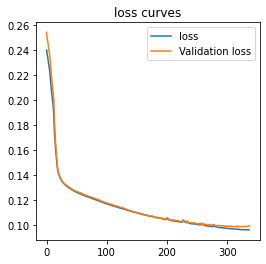

In [11]:
# %% Show loss evolution when training is done
loss = avg_train_losses
val_loss = avg_valid_losses
plt.figure(figsize=(4, 4))
plt.plot(loss[1:], '-', label='loss')
plt.plot(val_loss, '-', label='Validation loss')
plt.legend()
plt.title('loss curves')
# plt.savefig(model_dir + f'/{model_name}_Training_history.png')